# **Analyse et prétraitement**

<div class="alert alert-info">
Nous allons ici nous focaliser sur l'analyse et le traitement de base des images. L'étape de data augmentation sera directement intégrée lors de l'entraînement de notre modèle.
</div>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ImageFilter import MedianFilter
from PIL.ImageEnhance import Contrast
from PIL.ImageOps import autocontrast, equalize

import numpy as np
from glob import glob
import os
import shutil  # Pour supprimer un dossier non vide



In [10]:
path = "dogs_small/"
data_path = glob(path+'*/*.jp*')  # Récupération des chemins de tous les fichiers
suffixe = "_proc"

In [11]:
# Récupération des noms des dossiers (qui représentent les noms des labels)
# [len(path):] pour ne récupérer que les noms des dossiers, sans le chemin
list_labels = [os.path.dirname(dossier)[len(path):] for dossier in data_path]

# Récupération des noms de fichier (pour sauvegarde à la fin de nos traitements)
file_names = [os.path.basename(dossier) for dossier in data_path]

# Convertion des images en arrays
# img_array = [np.array(Image.open(ligne)) for ligne in data_path]

# Ouverture des images avec PIL.image
img_pil = [Image.open(ligne) for ligne in data_path]

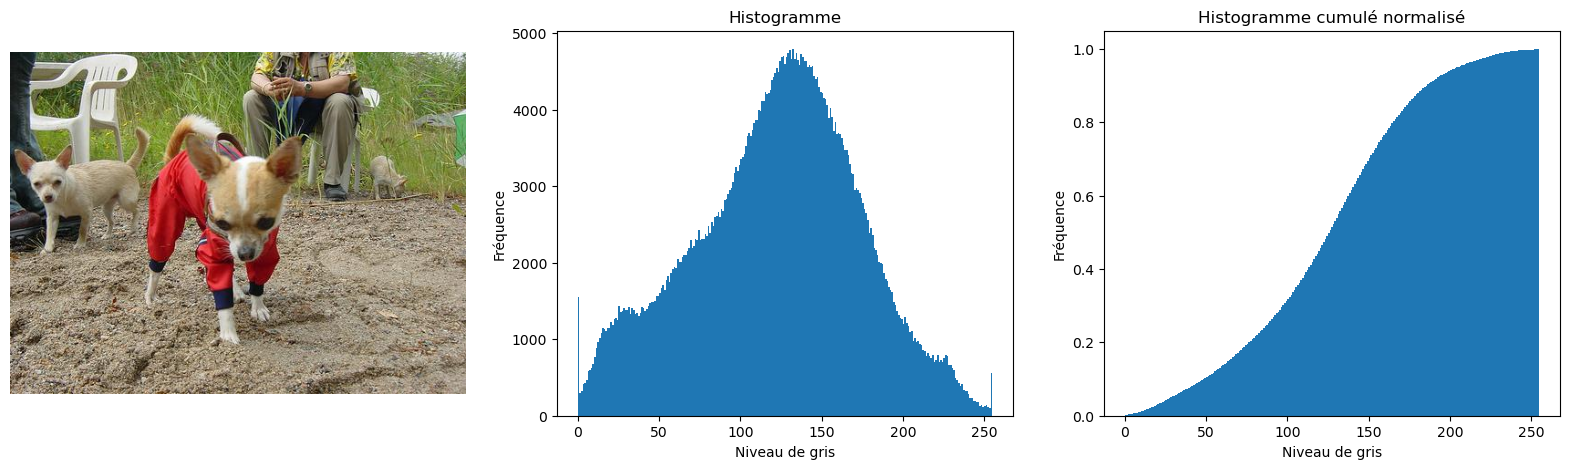

In [12]:
# Charger l'image comme matrice de pixels
img = np.array(img_pil[10])

# Générer et afficher l'histogramme à droite de l'image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Afficher l'image à gauche
ax1.imshow(np.array(img), cmap='gray')  # Spécifier la colormap 'gray' pour que ça soit bien interprété comme une image en noir et blanc
ax1.axis('off')  # Masquer les axes

# Générer et afficher l'histogramme à droite
ax2.hist(np.array(img).flatten(), bins=range(256))
ax2.set_title('Histogramme')
ax2.set_xlabel('Niveau de gris')
ax2.set_ylabel('Fréquence')

# Générer et afficher l'histogramme à droite
ax3.hist(np.array(img).flatten(), bins=range(256), density=True, cumulative=True)
ax3.set_title('Histogramme cumulé normalisé')
ax3.set_xlabel('Niveau de gris')
ax3.set_ylabel('Fréquence')

plt.show()

In [13]:
for i in range(len(img_pil)):

    img = img_pil[i]

    # Ajout de contraste
    img = Contrast(img).enhance(1.1)
    
    # Equalization de l'histogramme
    img = equalize(img)

    # Denoising léger
    #img = img.filter(MedianFilter(3))

    # Convertissez l'image de PIL en array NumPy
    img_pil[i] = img

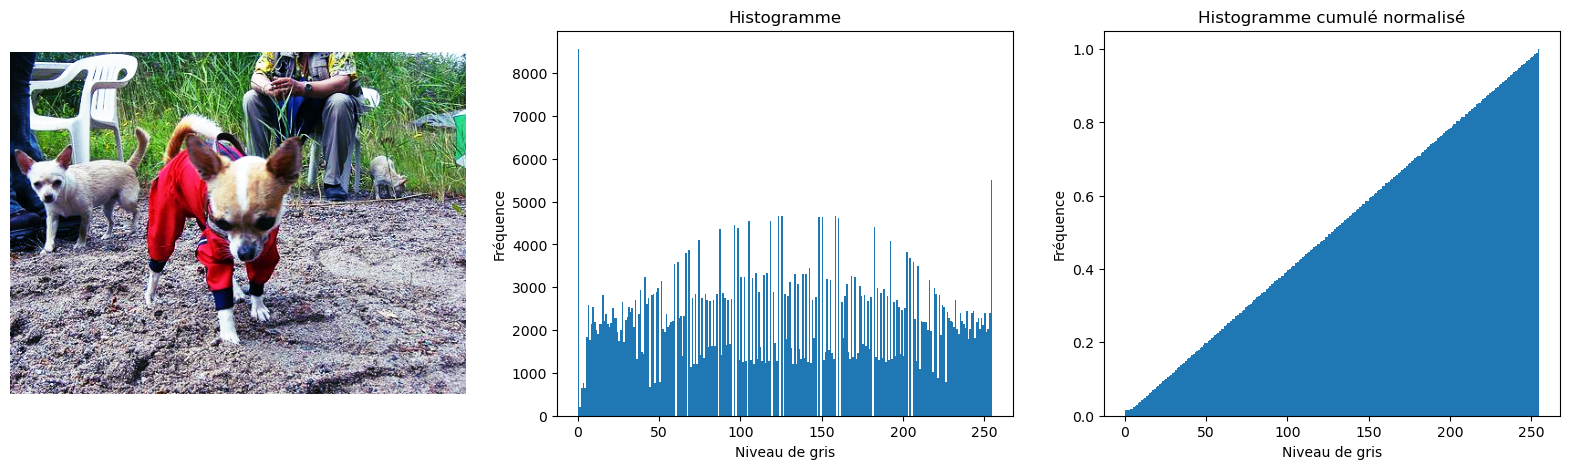

In [14]:
# Charger l'image comme matrice de pixels
img = np.array(img_pil[10])

# Générer et afficher l'histogramme à droite de l'image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Afficher l'image à gauche
ax1.imshow(np.array(img), cmap='gray')  # Spécifier la colormap 'gray' pour que ça soit bien interprété comme une image en noir et blanc
ax1.axis('off')  # Masquer les axes

# Générer et afficher l'histogramme à droite
ax2.hist(np.array(img).flatten(), bins=range(256))
ax2.set_title('Histogramme')
ax2.set_xlabel('Niveau de gris')
ax2.set_ylabel('Fréquence')

# Générer et afficher l'histogramme à droite
ax3.hist(np.array(img).flatten(), bins=range(256), density=True, cumulative=True)
ax3.set_title('Histogramme cumulé normalisé')
ax3.set_xlabel('Niveau de gris')
ax3.set_ylabel('Fréquence')

plt.show()

In [15]:
# im = Image.fromarray(data["img_array"][0])
# im.save("your_file.jpeg")

In [16]:
save_file = False

if save_file:

    # Dossier de sauvegarde : même nom que celui d'origine + suffixe
    dossier = path[:-1]+suffixe

    # Si le dossier existe déjà (précédente sauvagarde)
    # suppression du dossier et de son contenu avec shutil
    if os.path.exists(path[:-1]+suffixe):
        shutil.rmtree(dossier)

    # Création du dossier
    os.mkdir(dossier)

    # Récupération du nom des labels
    unique_labels = list(set(list_labels))

    # Création des sous dossiers qui auront le nom de chaque label
    for i in range(len(unique_labels)):
        os.mkdir(path[:-1]+suffixe+"/"+unique_labels[i])

    # Enregistrement de chaque image dans son dossier respectif
    for i in range(len(img_pil)):
        img_pil[i].save(dossier+"/"+list_labels[i]+"/"+file_names[i])